In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import synapseclient as sc
import warnings


warnings.simplefilter("ignore")
sns.set_style("dark")

%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [52]:
entity = syn.get("syn21046180")
data   = pd.read_csv(entity["path"], index_col = 0)

# Barplot on case matched data in mpowerV1

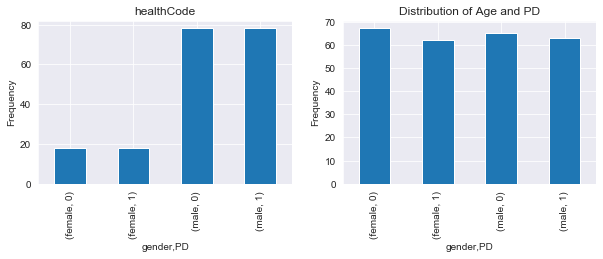

In [53]:
grouped = data.groupby(["gender", "PD"]).agg({"healthCode": lambda x: x.nunique(), "age": np.median})
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,3))
grouped["healthCode"].plot(kind = "bar", ax = axes[0],subplots=True, grid = True, figsize = (15,10))
plt.title("Distribution of Genders and PD")
axes[0].set_ylabel("Frequency")
grouped["age"].plot(kind = "bar", ax = axes[1],subplots=True, grid = True, figsize=(15,10))
plt.title("Distribution of Age and PD")
plt.ylabel("Frequency")

plt.show()

In [56]:
def plot_age_distribution(data):
    male_PD = data[(data["PD"] == 1) & (data["gender"] == "male")]["age"]
    male_NONPD = data[(data["PD"] == 0) & (data["gender"] == "male")]["age"]
    female_PD = data[(data["PD"] == 1) & (data["gender"] == "female")]["age"]
    female_NONPD = data[(data["PD"] == 0) & (data["gender"] == "female")]["age"]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    sns.distplot(male_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(male_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(female_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    sns.distplot(female_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    axes[0].grid()
    axes[0].set_title("Male Distribution")
    axes[1].grid()
    axes[1].set_title("Female Distribution")
    plt.legend()
    plt.show()

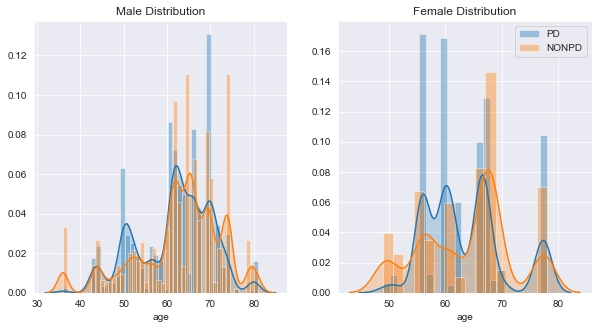

In [57]:
plot_age_distribution(data)

In [58]:
def aggregate_func(data, gender):
    if gender != "all":
        data = data[data["gender"] == gender]
    median_data = data.groupby("healthCode").median()
    mean_data = data.groupby("healthCode").mean()
    max_data = data.groupby("healthCode").max()
    min_data = data.groupby("healthCode").min()
    return median_data, mean_data, max_data, min_data

def plot_distribution(data):
    for i in [i for i in data.columns if ("." in i)]:
        PD = data[data["PD"] == True][i].dropna()
        NONPD = data[data["PD"] == False][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "PD", y = i, data = data, ax = axes[1], orient = "v", order = [True, False])
        axes[0].set_title("p-values: {}".format(ttest_ind(PD, NONPD)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
def rename_column_name(data,collapse_type):
    for feature in filter(lambda feature: ("." in feature), data.columns): 
        data  = data.rename({feature: "{}_{}"\
                            .format(collapse_type, feature)}, axis = 1)
    return data

# Some New Features

In [59]:
## number of steps that is based on resultant steps, not based on the resultant signals
data["fc.no_of_steps"] = np.sqrt(data["x.no_of_steps"] ** 2 + \
                            data["y.no_of_steps"] ** 2 + \
                            data["z.no_of_steps"] ** 2)


## the speed of gait based on the resultant speed of gait of X,Y,and Z not based on the speed of 
## gait assessed from the resultant signals
data["fc.speed_of_gait"] = np.sqrt(data["x.speed_of_gait"] ** 2 + \
                            data["y.speed_of_gait"] ** 2 + \
                            data["z.speed_of_gait"] ** 2)


## per second basis features ##
data["fc.no_of_steps_per_sec"] = data["fc.no_of_steps"]/data["duration"]
data["x.freeze_occurences_per_sec"] = data["x.freeze_occurences"]/data["duration"]
data["y.freeze_occurences_per_sec"] = data["y.freeze_occurences"]/data["duration"]
data["z.freeze_occurences_per_sec"] = data["z.freeze_occurences"]/data["duration"]
data["AA.freeze_occurences_per_sec"] = data["AA.freeze_occurences"]/data["duration"]

# Check Distributions between mean collapsed features

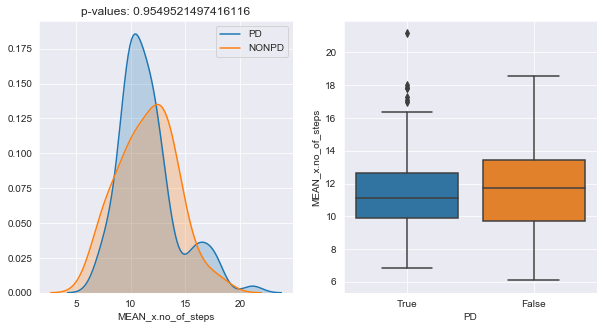

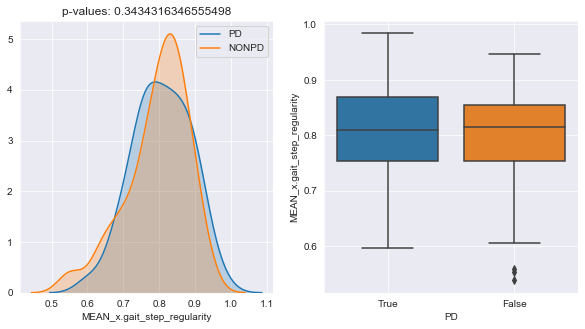

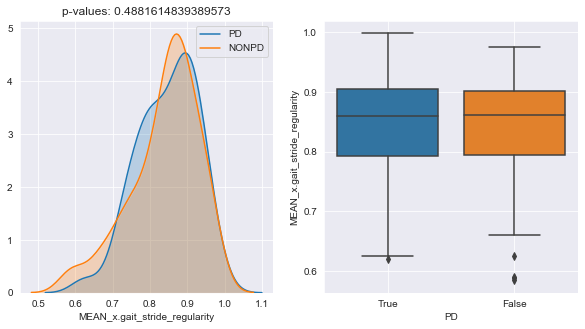

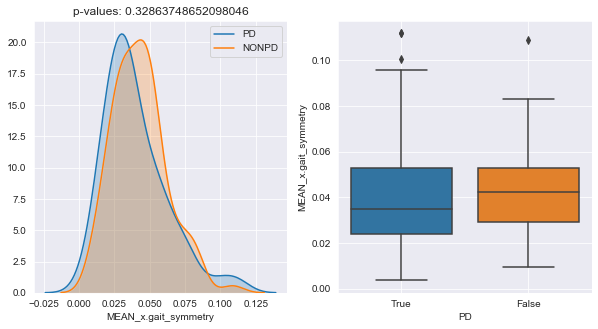

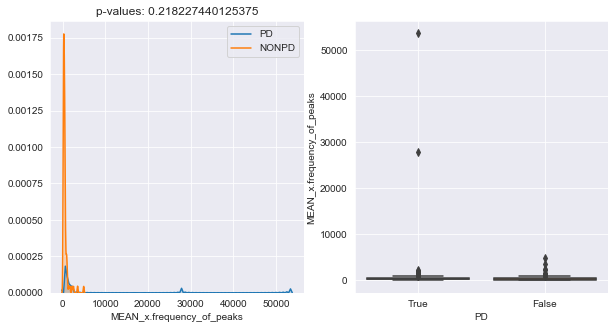

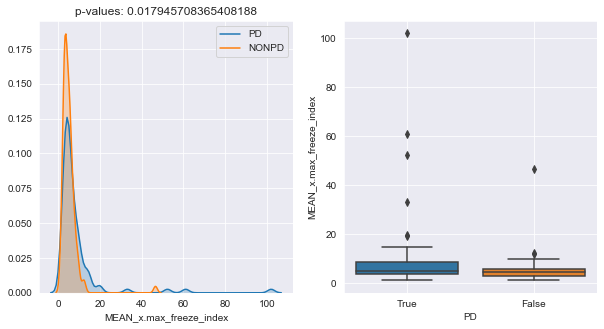

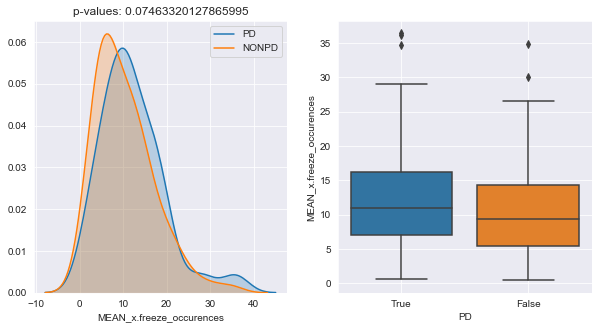

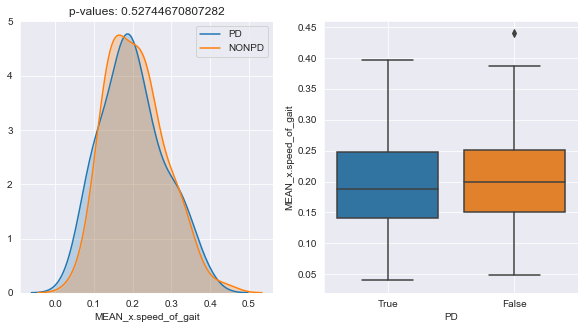

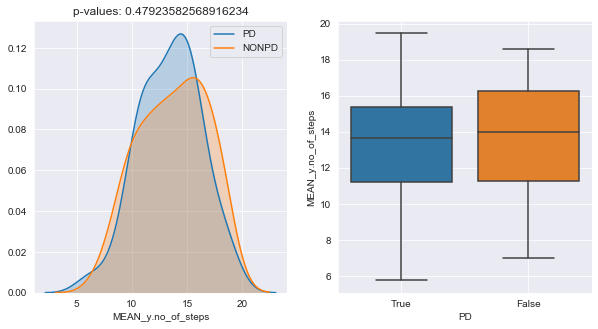

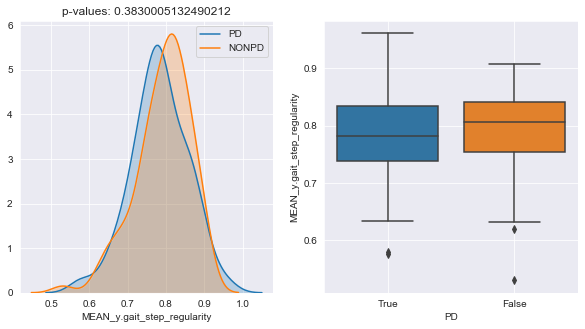

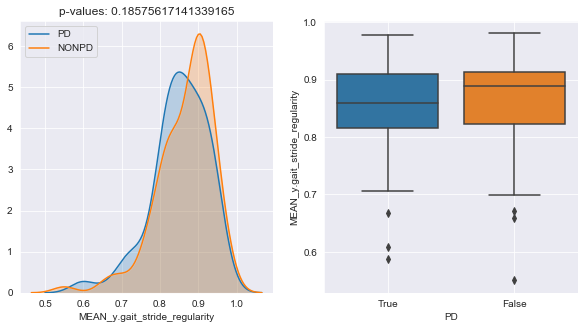

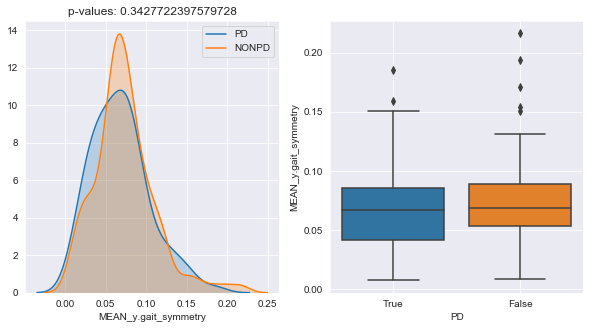

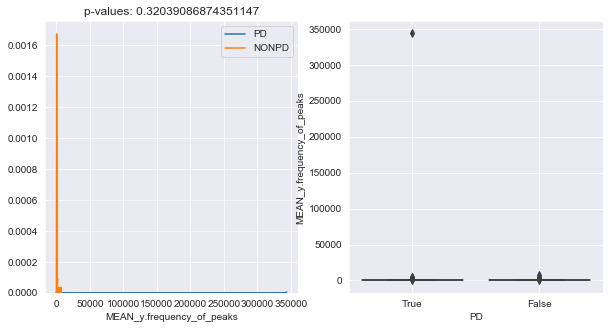

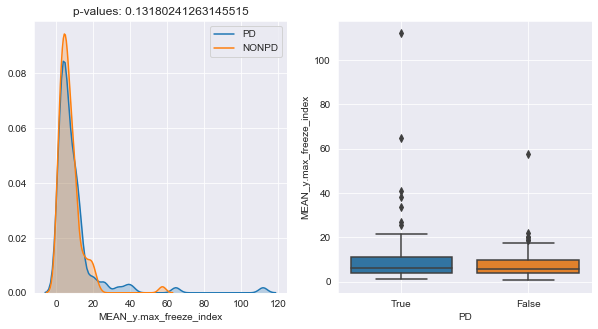

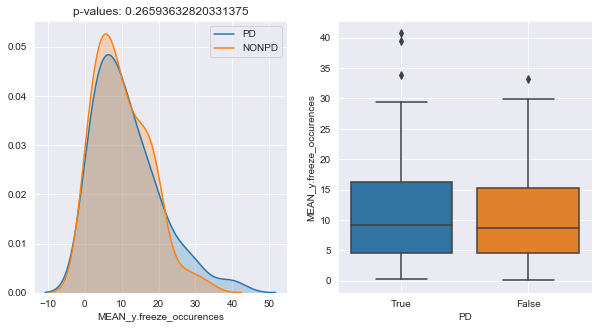

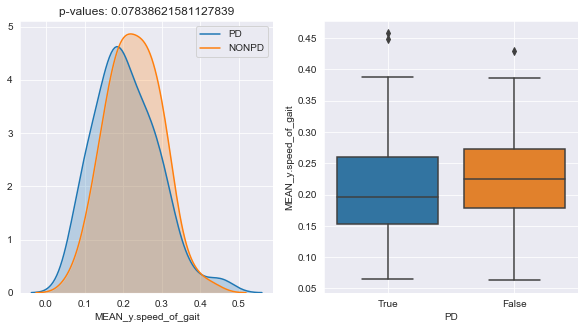

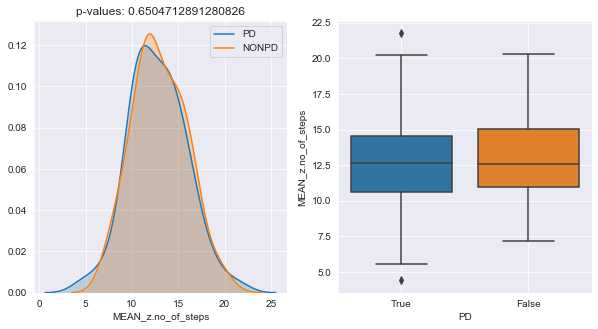

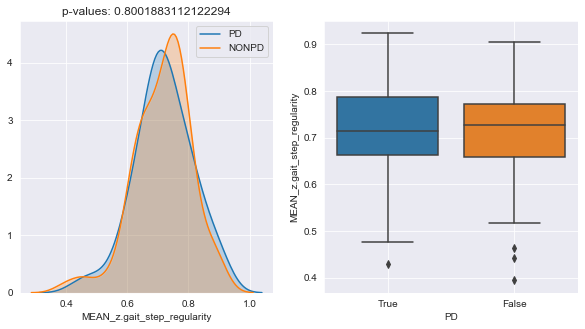

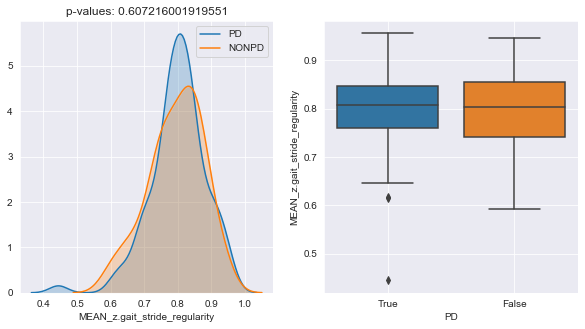

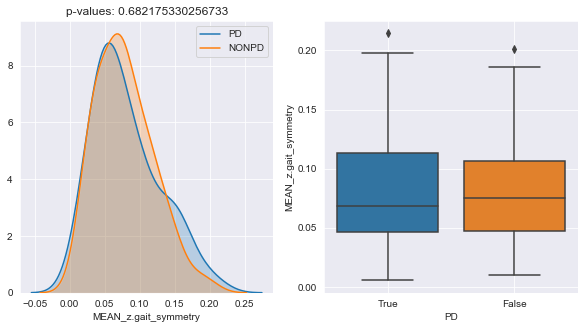

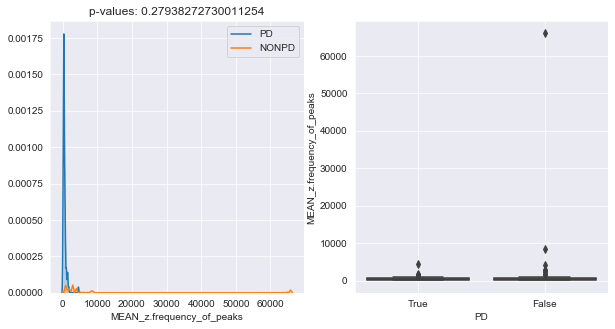

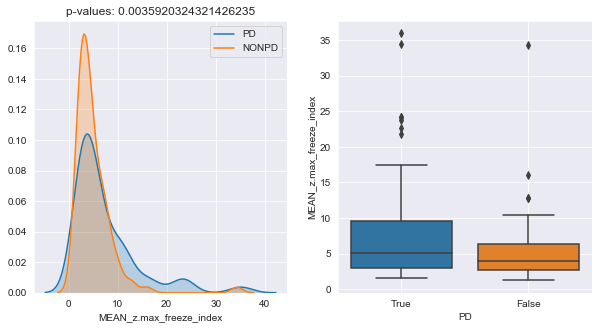

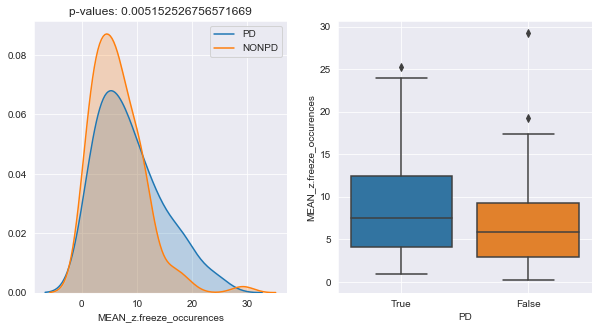

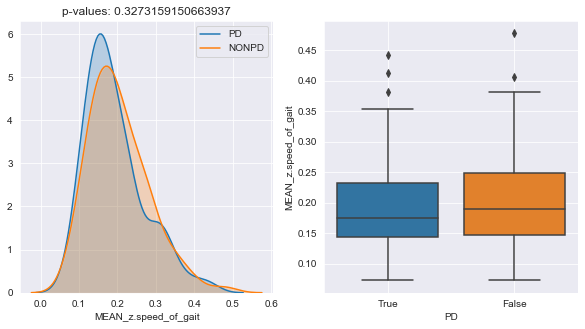

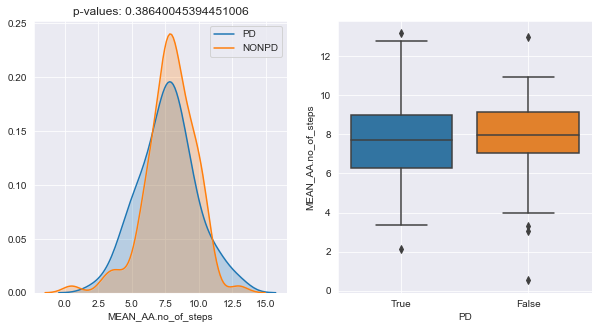

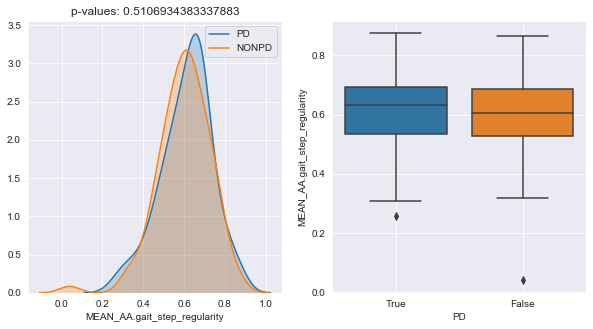

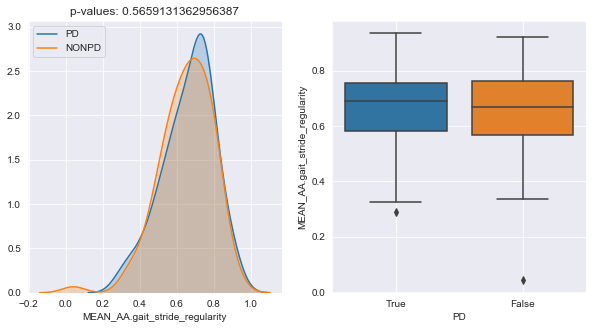

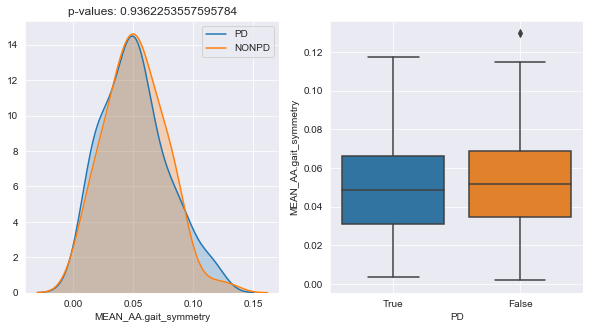

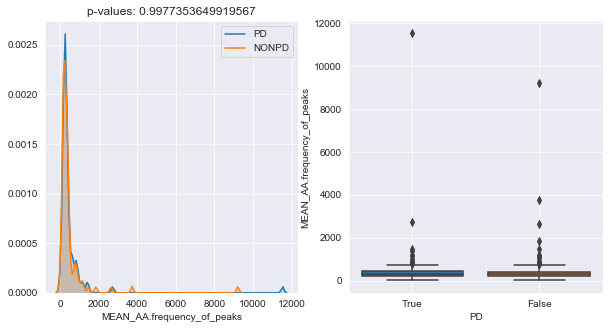

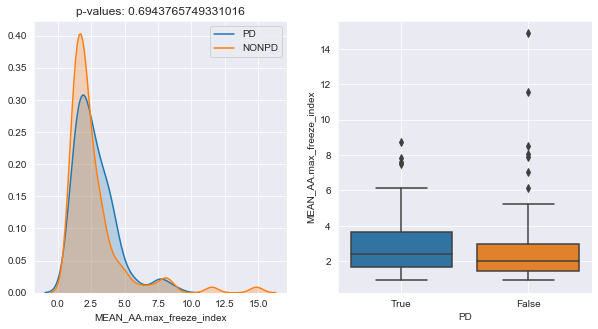

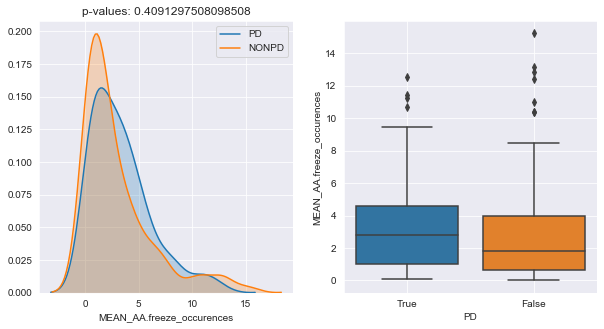

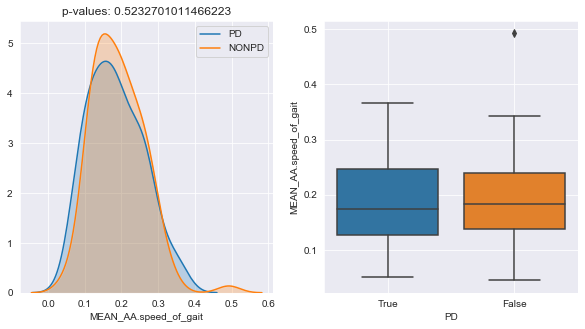

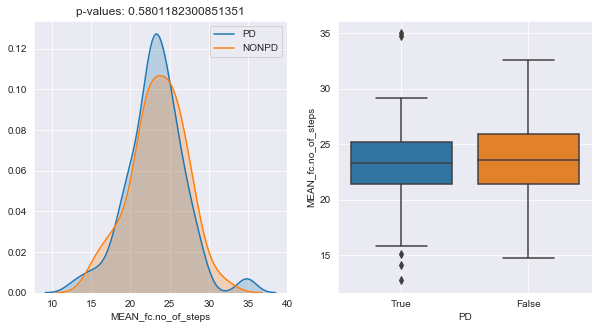

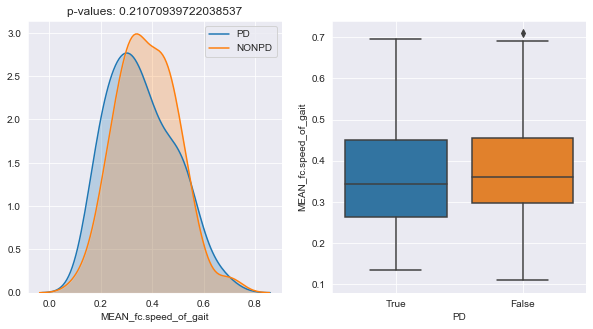

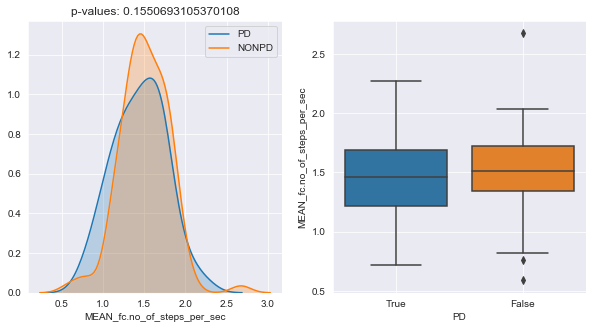

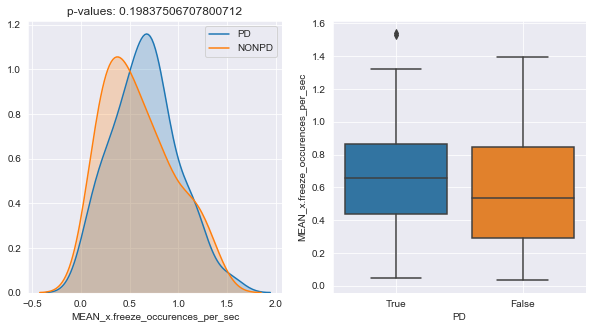

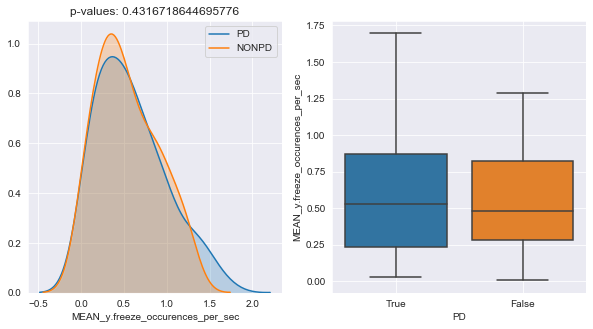

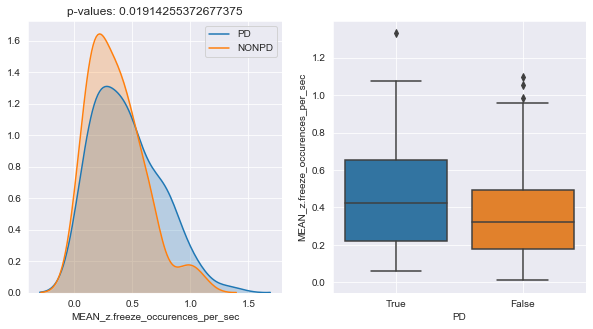

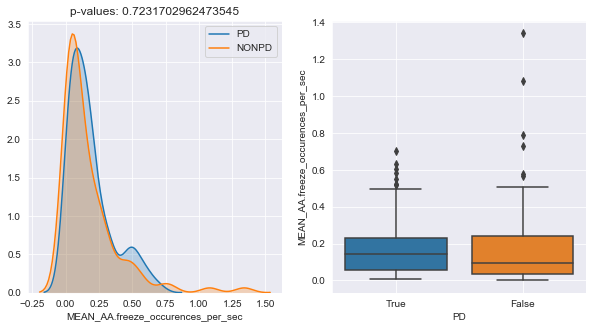

In [60]:
mean_data = data.groupby("healthCode").mean()
mean_data = rename_column_name(mean_data, "MEAN")
plot_distribution(mean_data)

# Check Distributions between max collapsed features

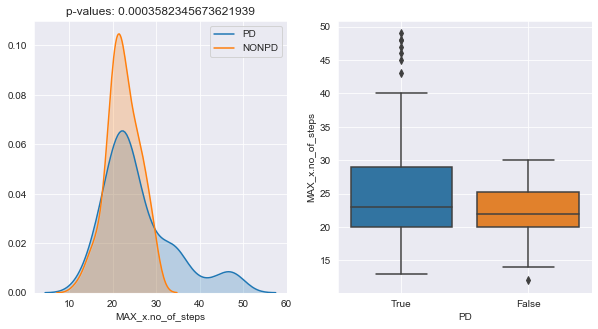

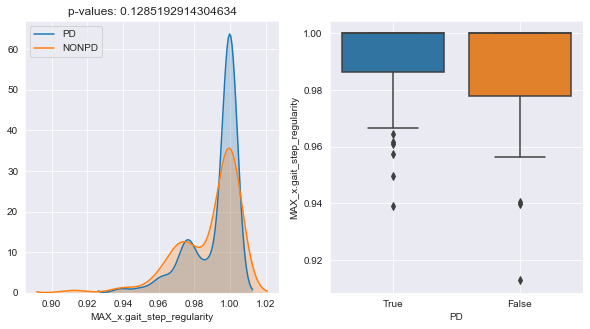

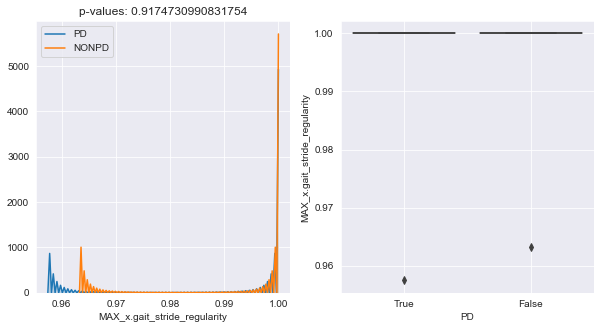

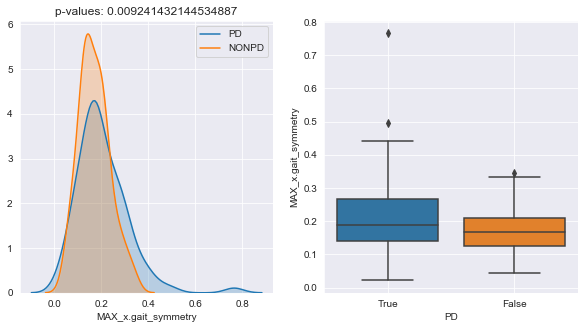

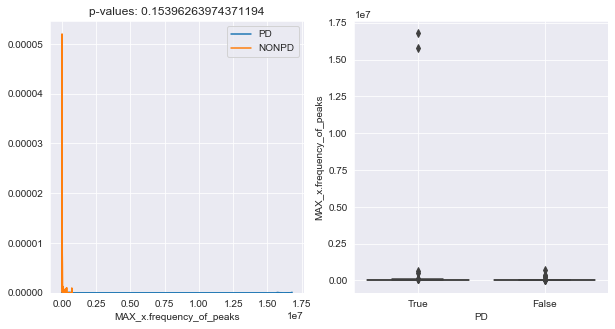

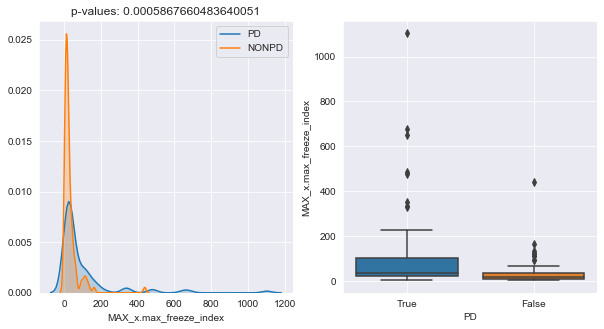

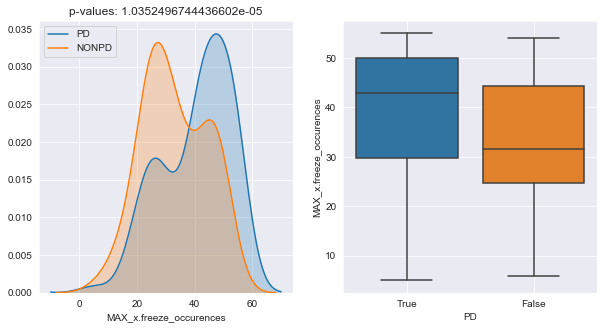

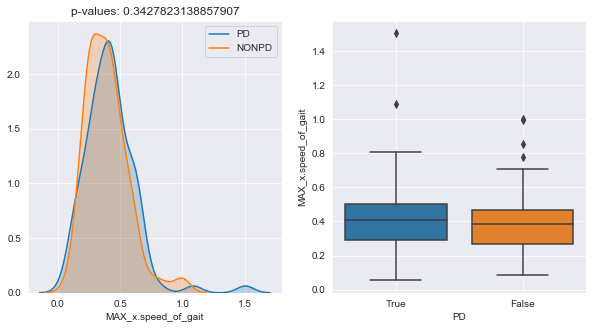

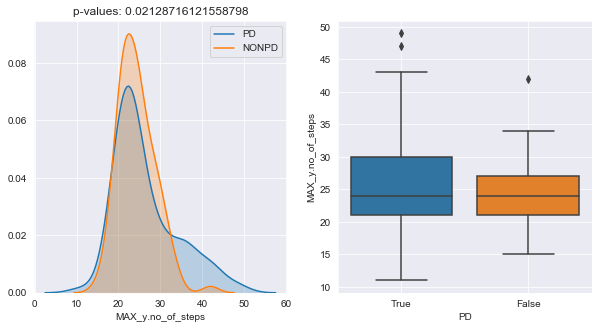

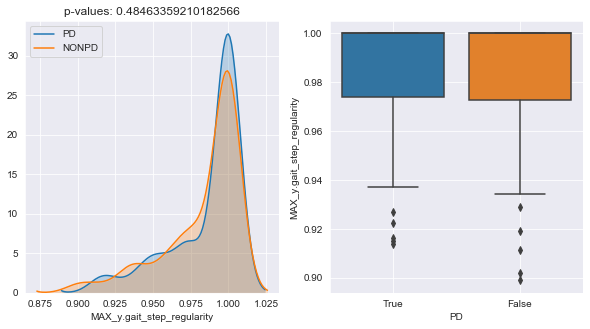

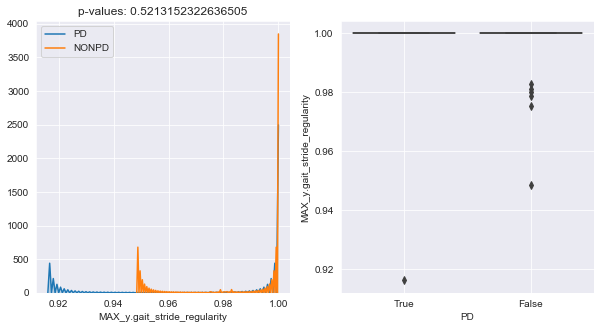

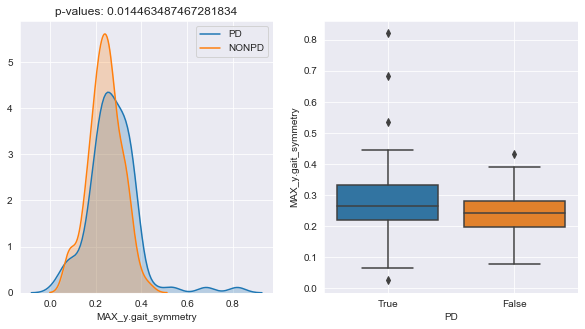

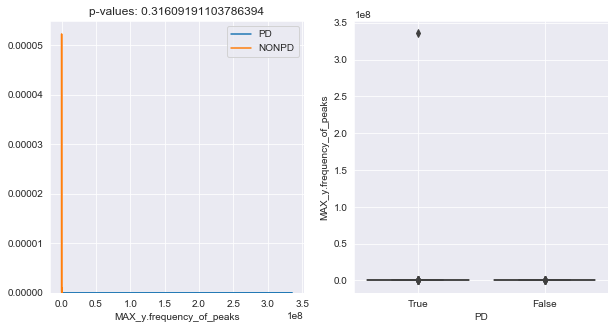

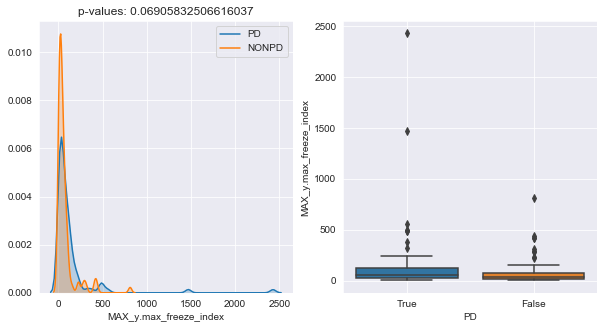

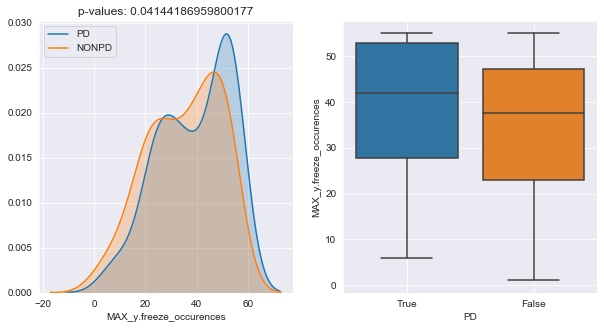

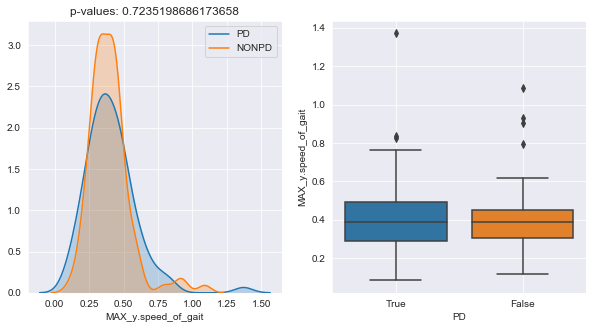

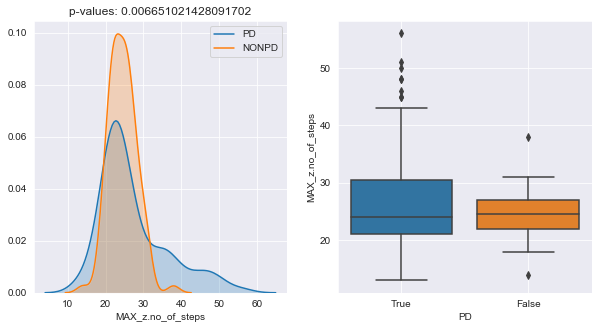

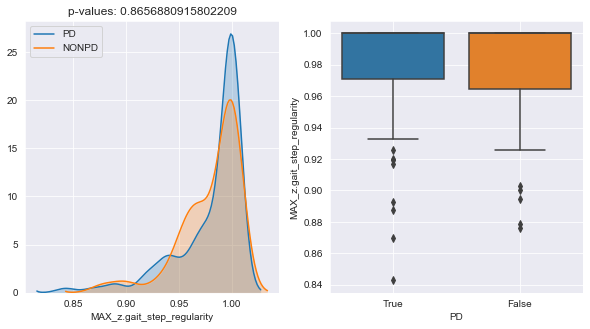

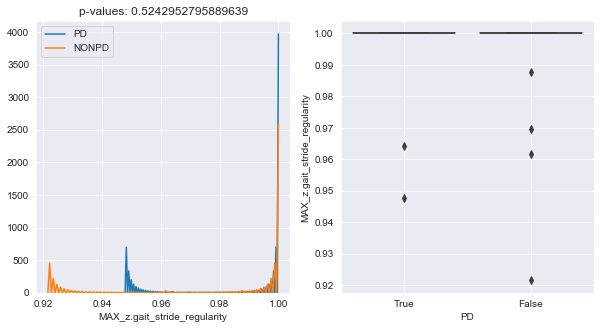

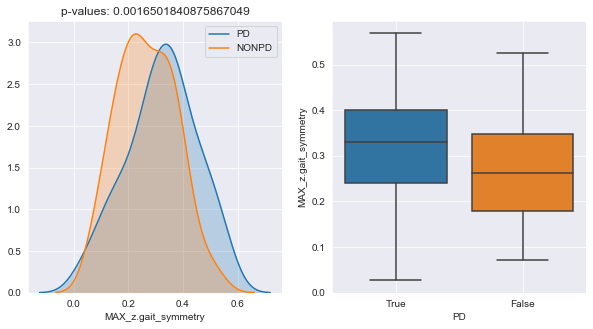

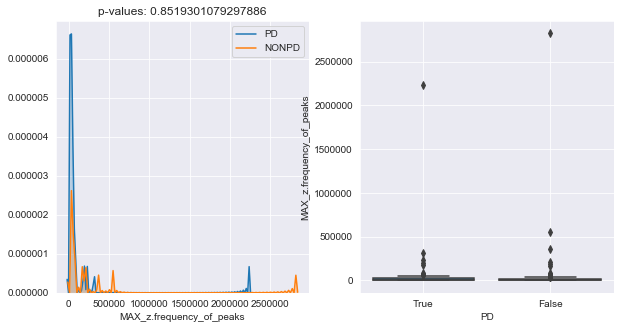

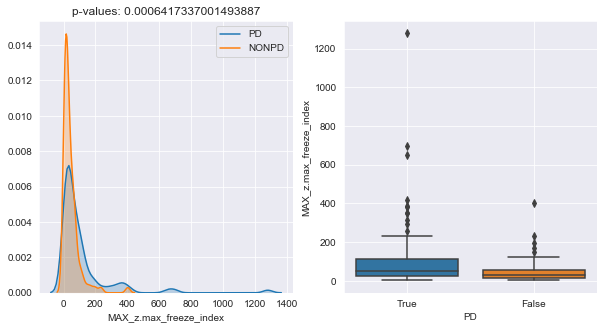

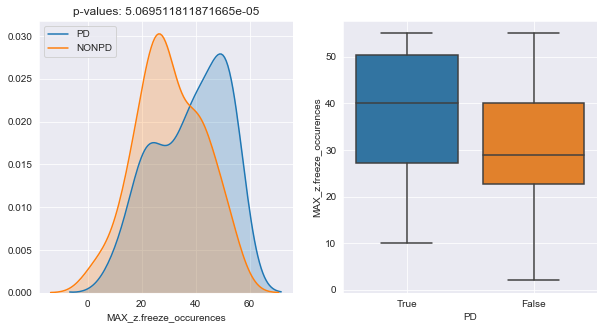

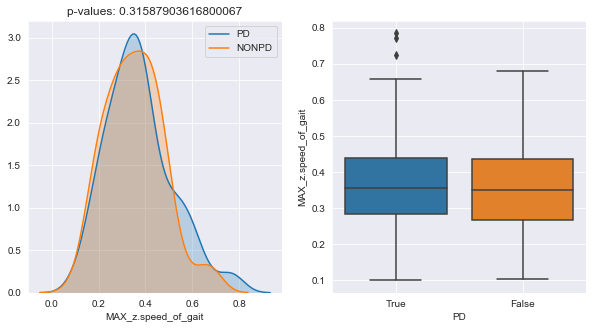

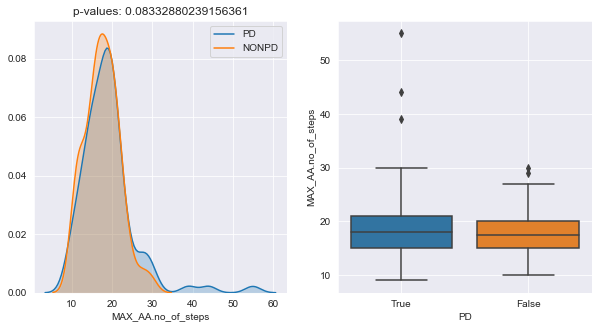

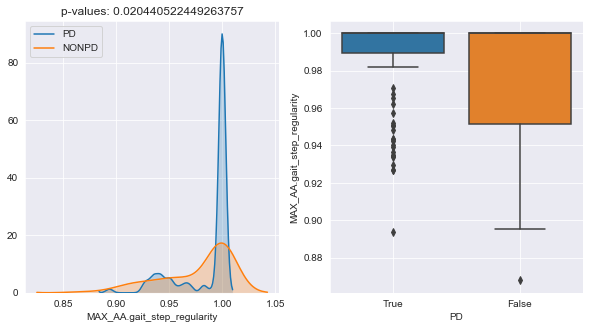

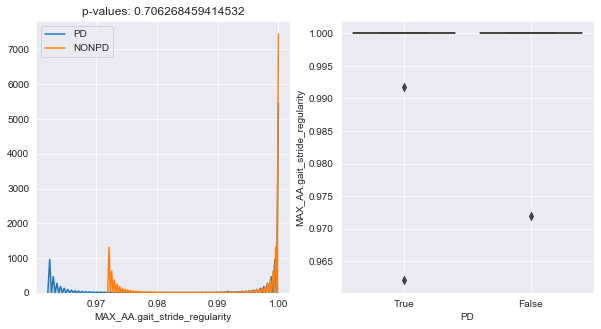

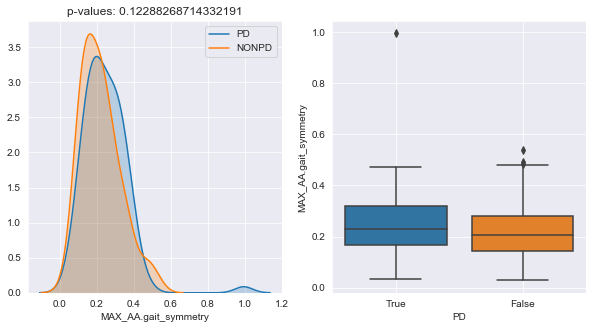

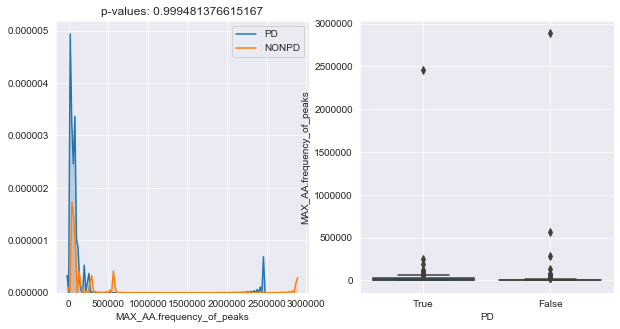

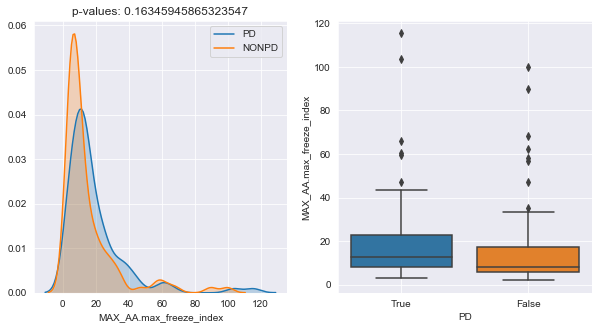

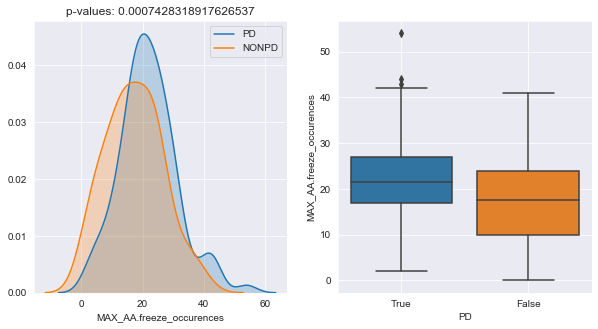

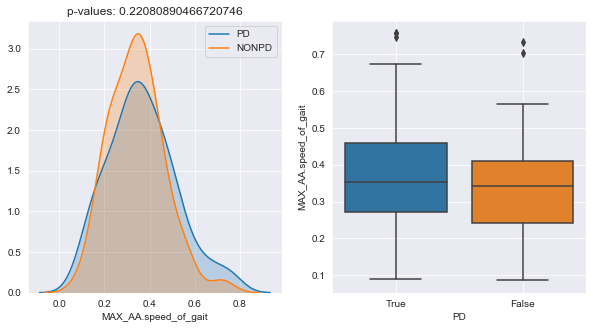

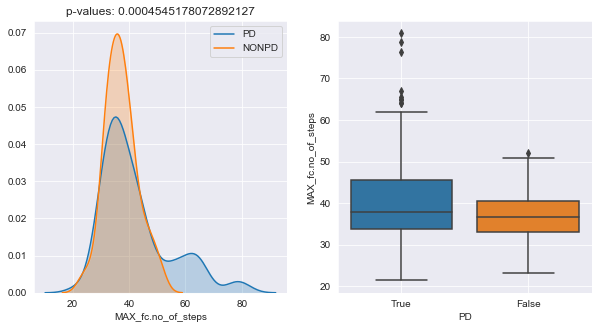

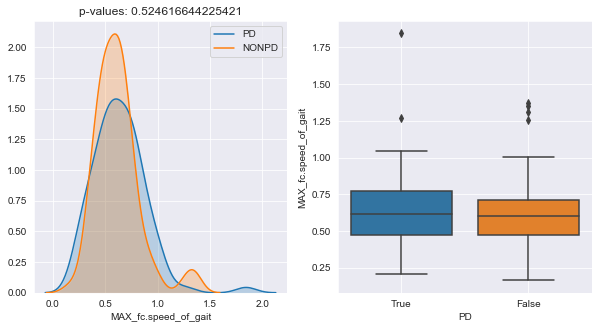

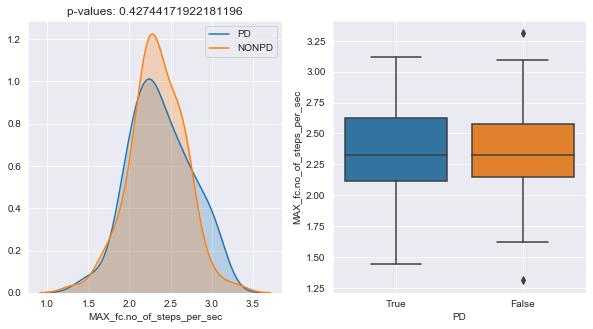

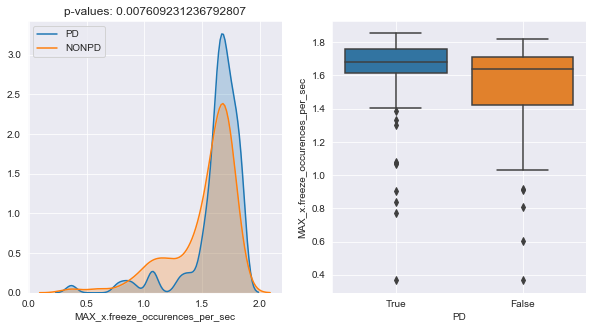

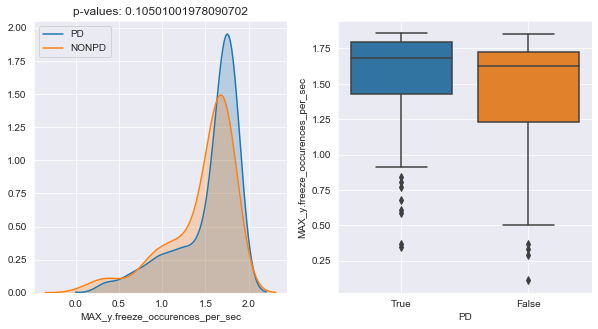

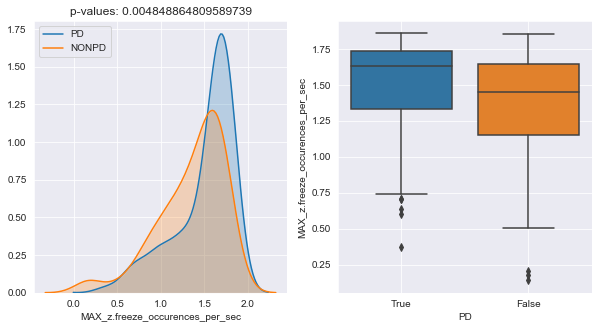

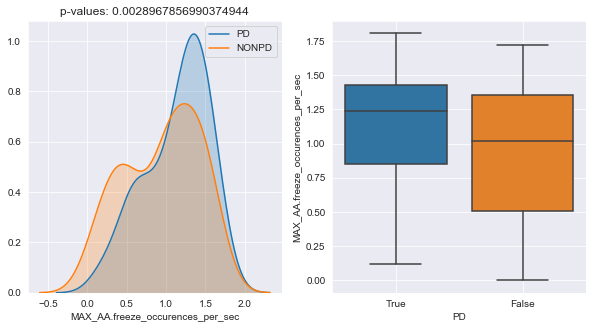

In [61]:
max_data = data.groupby("healthCode").max()
max_data = rename_column_name(max_data, "MAX")
plot_distribution(max_data)

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

In [63]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """Logarithm transformer."""

    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # to accomodate the pipeline
        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.variables:
            print(feature)
            X[feature] = np.where(X[feature] < 1, 0, np.log(X[feature]))
        return X

In [64]:
max_data = LogTransformer(variables = [feat for feat in max_data if "frequency_of_peaks" in feat]).transform(max_data)
mean_data = LogTransformer(variables = [feat for feat in mean_data if "frequency_of_peaks" in feat]).transform(mean_data)

MAX_x.frequency_of_peaks
MAX_y.frequency_of_peaks
MAX_z.frequency_of_peaks
MAX_AA.frequency_of_peaks
MEAN_x.frequency_of_peaks
MEAN_y.frequency_of_peaks
MEAN_z.frequency_of_peaks
MEAN_AA.frequency_of_peaks


# i).  Treating Outliers Frequency of Peaks

- From the maximum collapsed plot of frequency of peaks, it is apparent the data is severely having outliers in the data, which will result in bias when put to ML models, especially to distance-based algo and boosting models.

- Therefore, from the data that we have, we will apply log-transformation to the data and see whether gaussian can be attained from it. 

In [65]:
# max_fp_data = max_data[[feat for feat in max_data.columns if ("frequency_of_peaks" in feat) or ("PD" in feat)]]
# mean_fp_data = mean_data[[feat for feat in mean_data.columns if ("frequency_of_peaks" in feat) or ("PD" in feat)]]
for coord in ["x", "y", "z", "AA"]:
    max_feat = "MAX_%s.log_frequency_of_peaks"%coord
    mean_feat = "MEAN_%s.log_frequency_of_peaks"%coord
    max_data[max_feat] = \
    np.where(max_data["MAX_%s.frequency_of_peaks"%coord] < 1, 
             0, np.log(max_data["MAX_%s.frequency_of_peaks"%coord]))
    mean_data[mean_feat] = \
    np.where(mean_data["MEAN_%s.frequency_of_peaks"%coord] < 1, 
             0, np.log(mean_data["MEAN_%s.frequency_of_peaks"%coord]))

### Log Transformed Frequency of Peaks

In [66]:
# max_data["max_x.log_frequency_of_peaks"] = np.log(max_data[["max_x.frequency_of_peaks"]])
# max_data["max_y.log_frequency_of_peaks"] = np.log(max_data[["max_y.frequency_of_peaks"]])
# max_data["max_z.log_frequency_of_peaks"] = np.log(max_data[["max_z.frequency_of_peaks"]])
# max_data["max_AA.log_frequency_of_peaks"] = np.log(max_fp_data[["max_AA.frequency_of_peaks"]])

# mean_data["mean_x.log_frequency_of_peaks"] = np.log(mean_fp_data[["mean_x.frequency_of_peaks"]])
# mean_data["mean_y.log_frequency_of_peaks"] = np.log(mean_fp_data[["mean_y.frequency_of_peaks"]])
# mean_data["mean_z.log_frequency_of_peaks"] = np.log(mean_fp_data[["mean_z.frequency_of_peaks"]])
# mean_data["mean_AA.log_frequency_of_peaks"] = np.log(mean_fp_data[["mean_AA.frequency_of_peaks"]])

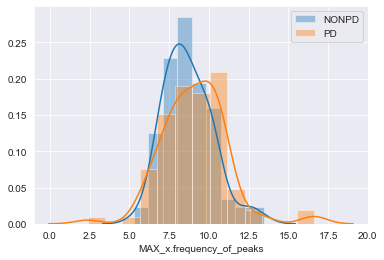

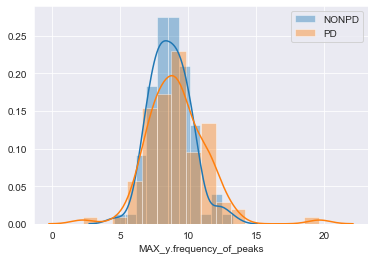

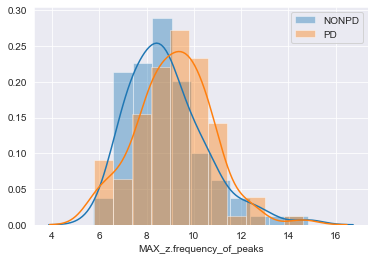

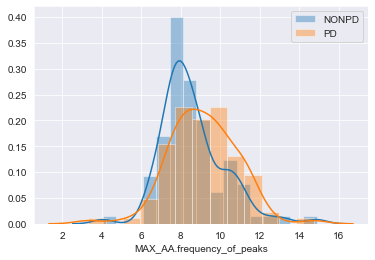

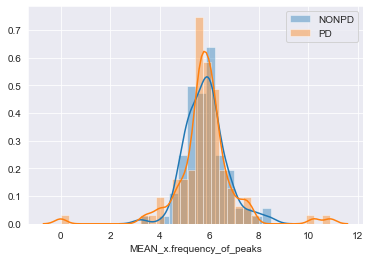

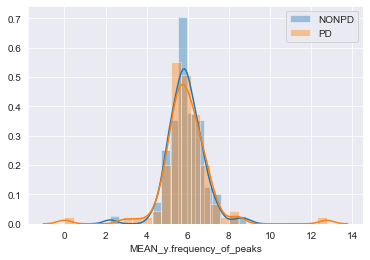

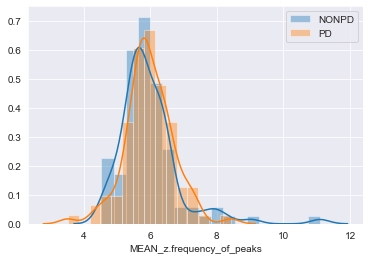

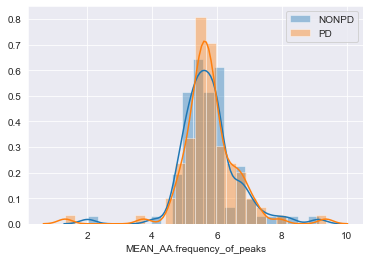

In [67]:
for coord in ["x", "y", "z", "AA"]:
    sns.distplot(max_data[max_data["PD"] == 0]["MAX_{}.frequency_of_peaks".format(coord)], label = "NONPD")
    sns.distplot(max_data[max_data["PD"] == 1]["MAX_{}.frequency_of_peaks".format(coord)], label = "PD")
    plt.legend()
    plt.grid()
    plt.show()

for coord in ["x", "y", "z", "AA"]:
    sns.distplot(mean_data[mean_data["PD"] == 0]["MEAN_{}.frequency_of_peaks".format(coord)], label = "NONPD")
    sns.distplot(mean_data[mean_data["PD"] == 1]["MEAN_{}.frequency_of_peaks".format(coord)], label = "PD")
    plt.legend()
    plt.grid()
    plt.show()

# Save to CSV

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

Usng both max and mean collapsed data, KBest Chi-Squared test will be used to see which features are best able to predict PD subjects. Afterwards, feature selection will be conducted. Side Note: K-Best will be done only to the training sets, and we will keep test sets away to not hinder the process of feature selection. (peeking)

In [69]:
## combine datas ##
combined_data = pd.concat([mean_data, max_data], axis = 1)
y = max_data["PD"]
# frequency_of_peaks_cols = [feat for feat in combined_data.columns if ("frequency_of_peaks" in feat) 
#                            and ("log" not in feat)]
# stride_regularity_cols = [feat for feat in combined_data.columns if ("stride_regularity" in feat)]

# ## clean data values ##
# combined_data.drop(frequency_of_peaks_cols, axis = 1, inplace = True)
# combined_data.drop(stride_regularity_cols, axis = 1, inplace = True)

In [70]:
MAX_FEATURES  = [i for i in combined_data.columns if ("." in i) and ("MAX" in i)]
MEAN_FEATURES = [i for i in combined_data.columns if ("." in i) and ("MEAN" in i)]
COMBINED_FEATURES = [i for i in combined_data.columns if ("." in i)]

In [71]:
MAX_FEATURES

['MAX_x.no_of_steps',
 'MAX_x.gait_step_regularity',
 'MAX_x.gait_stride_regularity',
 'MAX_x.gait_symmetry',
 'MAX_x.frequency_of_peaks',
 'MAX_x.max_freeze_index',
 'MAX_x.freeze_occurences',
 'MAX_x.speed_of_gait',
 'MAX_y.no_of_steps',
 'MAX_y.gait_step_regularity',
 'MAX_y.gait_stride_regularity',
 'MAX_y.gait_symmetry',
 'MAX_y.frequency_of_peaks',
 'MAX_y.max_freeze_index',
 'MAX_y.freeze_occurences',
 'MAX_y.speed_of_gait',
 'MAX_z.no_of_steps',
 'MAX_z.gait_step_regularity',
 'MAX_z.gait_stride_regularity',
 'MAX_z.gait_symmetry',
 'MAX_z.frequency_of_peaks',
 'MAX_z.max_freeze_index',
 'MAX_z.freeze_occurences',
 'MAX_z.speed_of_gait',
 'MAX_AA.no_of_steps',
 'MAX_AA.gait_step_regularity',
 'MAX_AA.gait_stride_regularity',
 'MAX_AA.gait_symmetry',
 'MAX_AA.frequency_of_peaks',
 'MAX_AA.max_freeze_index',
 'MAX_AA.freeze_occurences',
 'MAX_AA.speed_of_gait',
 'MAX_fc.no_of_steps',
 'MAX_fc.speed_of_gait',
 'MAX_fc.no_of_steps_per_sec',
 'MAX_x.freeze_occurences_per_sec',
 'MAX

## Save data to ../Data Folders

In [72]:
MAX_DATA = pd.concat([combined_data[MAX_FEATURES], y], axis = 1).to_csv("../Data/MAX_DATA.csv")
MEAN_DATA = pd.concat([combined_data[MEAN_FEATURES], y], axis = 1).to_csv("../Data/MEAN_DATA.csv")
COMBINED_DATA = pd.concat([combined_data[COMBINED_FEATURES], y], axis = 1).to_csv("../Data/COMBINED_DATA.csv")

# Side Note

- Remove stride_regularity data: due to 90% of data being the same value

- Remove freeze_occurences data: as different versions can bias the results

- Remove number of steps: as different versions can bias the results